In [16]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import Dataset, DataLoader

In [11]:
NUM_CLASSES = 2
BATCH_SIZE = 64
NUM_WORKERS = 4

EPOCHS = 10
# Initial learning rate
LR = 1e-2
# Learning rate decay for LR Scheduler
GAMMA = 0.5

# Input image dimensions
H = 224
W = 224

In [12]:
TRAIN_FOLDER = '/Volumes/Project/Competition/IIT Madras/dataset/train'
TEST_FOLDER = '/Volumes/Project/Competition/IIT Madras/dataset/test'

In [13]:
def get_transforms(train):
    # Since we are using pretrained ResNet-50, normalize images with ImageNet statistics
    normalization = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    if (train):
        return transforms.Compose([transforms.RandomCrop((H, W)),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   normalization,
                                   ])
    else:
        return transforms.Compose([transforms.Resize((H, W)),
                                   transforms.ToTensor(),
                                   normalization,
                                  ])

In [14]:
train_dataset = ImageFolder(root=TRAIN_FOLDER, transform=get_transforms(train=True))
test_dataset = ImageFolder(root=TEST_FOLDER, transform=get_transforms(train=False))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [15]:
# Display image and label.
train_features, train_labels = next(iter(test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[4].squeeze()
label = train_labels[4]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Label: 1


In [16]:
def show_batch(batch_images, batch_labels, n_rows, n_cols):
    batch_size = len(batch_labels)
    assert batch_size == n_rows * n_cols
    plt.figure(figsize=(n_rows * 2, n_cols * 2))
    for i in range(batch_size):
        plt.subplot(n_cols, n_rows, i + 1)
        plt.title(batch_labels[i].item())
        plt.imshow(batch_images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

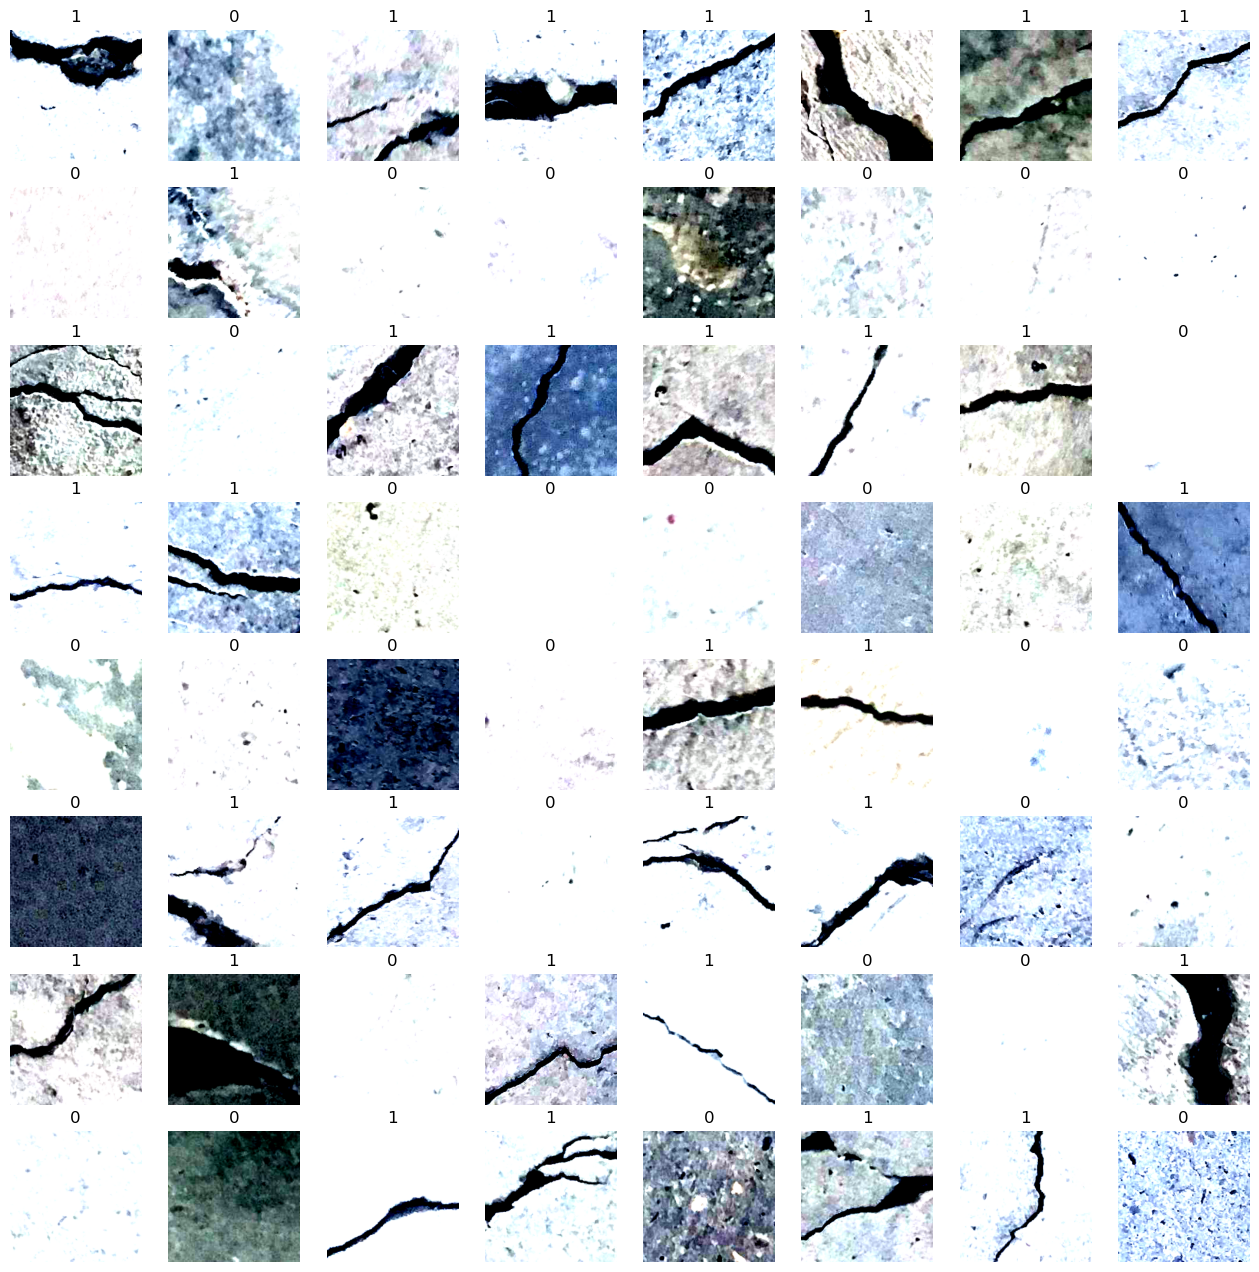

In [17]:
batch_images, batch_labels = next(iter(train_loader))
show_batch(batch_images, batch_labels, 8, 8);

In [17]:
class CrackPredictorModel(nn.Module):
    def __init__(self, n_classes=2):
        super(CrackPredictorModel, self).__init__()
        # Get pretrained ResNet50 backbone
        self.backbone = models.resnet50(weights='DEFAULT')
        
        # Freeze backbone layers
        for parameter in self.backbone.parameters():
            parameter.requires_grad = False   
        
        # Add new head
        self.backbone.fc = nn.Sequential(nn.Linear(2048, 128),
                                         nn.ReLU(),
                                         nn.Linear(128, n_classes),
                                        )

    def forward(self, x):
        return self.backbone(x)

In [19]:
device = torch.device("mps")

In [20]:
model = CrackPredictorModel(n_classes=NUM_CLASSES).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.6 * EPOCHS), int(0.8 * EPOCHS)], gamma=GAMMA)

CrackPredictorModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [21]:
def calculate_batch_metrics(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    results = predicted == y
    accuracy = results.sum() / results.shape[0]
    correct_true = (results * predicted == 1).sum()
    precision = correct_true / ((predicted == 1).sum())
    recall = correct_true / ((y == 1).sum())
    return accuracy.item(), precision.item(), recall.item()

def train(model, train_loader, criterion, optimizer, scheduler, device):
    epoch_loss = 0
    steps = 0
    epoch_accuracy = 0
    epoch_precision = 0
    epoch_recall = 0

    model.train()
    for images, labels in tqdm(train_loader):
        steps += 1
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        accuracy, precision, recall = calculate_batch_metrics(outputs, labels)
        epoch_accuracy += accuracy
        epoch_precision += precision
        epoch_recall += recall

        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
       
    scheduler.step()
    epoch_loss /= steps
    epoch_accuracy = 100.0 * epoch_accuracy / steps
    epoch_precision = 100.0 * epoch_precision / steps
    epoch_recall = 100.0 * epoch_recall / steps

    print(f"Train epoch Loss: {epoch_loss:.5f} Accuracy: {epoch_accuracy:.3f} % Precision: {epoch_precision:.3f} % Recall: {epoch_recall:.3f} %")
    return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall
    
def test(model, test_loader, criterion, device):
    test_loss = 0
    steps = 0
    test_accuracy = 0
    test_precision = 0
    test_recall = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            accuracy, precision, recall = calculate_batch_metrics(outputs, labels)
            test_accuracy += accuracy
            test_precision += precision
            test_recall += recall
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        test_loss /= steps
        test_accuracy = 100.0 * test_accuracy / steps
        test_precision = 100.0 * test_precision / steps
        test_recall = 100.0 * test_recall / steps
        test_f1Score = (2*test_precision*test_recall)/(test_precision + test_recall)
        print(f"Test Loss: {test_loss:.5f} Accuracy: {test_accuracy:.3f} % Precision: {test_precision:.3f} % Recall: {test_recall:.3f} % F1-Score: {test_f1Score:.3f} %")

In [22]:
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []

for epoch in range(EPOCHS):
    loss, accuracy, precision, recall = train(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(loss)
    train_accuracies.append(accuracy)
    train_precisions.append(precision)
    train_recalls.append(recall)    

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


Train epoch Loss: 0.04383 Accuracy: 98.370 % Precision: nan % Recall: 98.387 %


100%|██████████| 625/625 [04:03<00:00,  2.57it/s]


Train epoch Loss: 0.02867 Accuracy: 99.073 % Precision: 99.085 % Recall: 99.067 %


100%|██████████| 625/625 [14:00<00:00,  1.35s/it]  


Train epoch Loss: 0.01916 Accuracy: 99.328 % Precision: 99.336 % Recall: 99.305 %


100%|██████████| 625/625 [10:56<00:00,  1.05s/it]   


Train epoch Loss: 0.01823 Accuracy: 99.388 % Precision: 99.370 % Recall: 99.413 %


100%|██████████| 625/625 [13:17<00:00,  1.28s/it]


Train epoch Loss: 0.01694 Accuracy: 99.450 % Precision: 99.413 % Recall: 99.488 %


100%|██████████| 625/625 [06:28<00:00,  1.61it/s]


Train epoch Loss: 0.01717 Accuracy: 99.390 % Precision: 99.352 % Recall: 99.446 %


100%|██████████| 625/625 [07:20<00:00,  1.42it/s]  


Train epoch Loss: 0.01103 Accuracy: 99.627 % Precision: 99.613 % Recall: 99.640 %


100%|██████████| 625/625 [09:35<00:00,  1.09it/s]  


Train epoch Loss: 0.01232 Accuracy: 99.593 % Precision: 99.513 % Recall: 99.675 %


100%|██████████| 625/625 [06:01<00:00,  1.73it/s]  


Train epoch Loss: 0.01123 Accuracy: 99.615 % Precision: 99.580 % Recall: 99.648 %


100%|██████████| 625/625 [04:04<00:00,  2.56it/s]

Train epoch Loss: 0.00980 Accuracy: 99.672 % Precision: 99.652 % Recall: 99.691 %


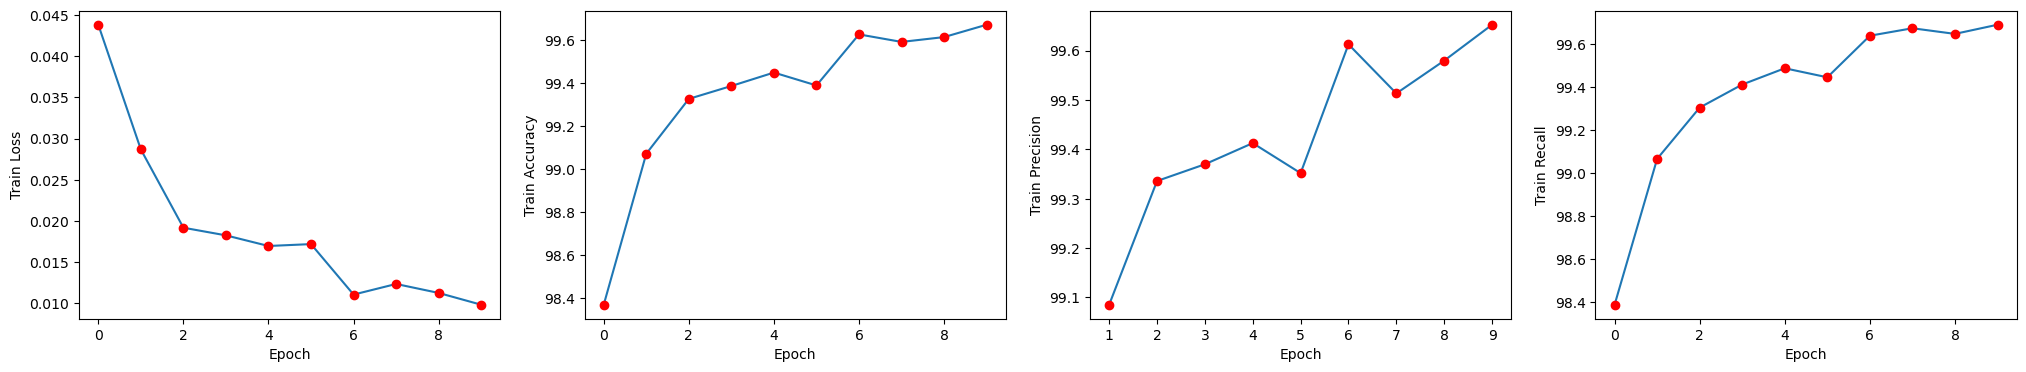

In [23]:
plt.figure(figsize=(25, 4))
plt.subplot(1, 4, 1)
plt.plot(train_losses, zorder=1)
plt.scatter([i for i in range(len(train_losses))], train_losses, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")

plt.subplot(1, 4, 2)
plt.plot(train_accuracies, zorder=1)
plt.scatter([i for i in range(len(train_accuracies))], train_accuracies, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")

plt.subplot(1, 4, 3)
plt.plot(train_precisions, zorder=1)
plt.scatter([i for i in range(len(train_precisions))], train_precisions, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Precision")

plt.subplot(1, 4, 4)
plt.plot(train_recalls, zorder=1)
plt.scatter([i for i in range(len(train_recalls))], train_recalls, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Recall")
plt.show()

In [24]:
test(model, test_loader, criterion, device)

100%|██████████| 4/4 [00:22<00:00,  5.65s/it]

Test Loss: 0.04151 Accuracy: 99.219 % Precision: 100.000 % Recall: 98.403 % F1-Score: 99.195 %


In [29]:
INFERENCE_FOLDER = '/Volumes/Project/Competition/IIT Madras/dataset/valid/'

In [30]:
class InferenceDataset(Dataset):
    def __init__(self, folder, transform):
        self.folder = Path(folder)
        self.transform = transform
        self.image_paths = [x for x in self.folder.glob('**/*') if x.is_file()]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        transformed_image = self.transform(image)
        return transformed_image, self.image_paths[idx].name
    
def inference(model, inference_loader):
    result = [[], []]
    model.eval()
    with torch.no_grad():
        for images, paths in inference_loader:
            paths = list(paths)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            result[0].extend(paths)
            result[1].extend(predicted.cpu().numpy())
    return pd.DataFrame(np.array(result).T, columns = ['file', 'label'])

In [31]:
inference_dataset = InferenceDataset(INFERENCE_FOLDER, get_transforms(train=False))
inference_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
inference(model, inference_loader)

,file,label
0,IMG_9333_11_10.jpg,1
1,IMG_9703_6_14.jpg,1
2,IMG_9147_9_15.jpg,1
3,IMG_9303_7_4.jpg,1
4,IMG_9398_6_10.jpg,1
...,...,...
195,IMG_9186_1_7.jpg,0
196,IMG_0493_7_10.jpg,0
197,IMG_0492_12_15.jpg,0
198,IMG_3022_9_1.jpg,0


In [35]:
PATH = "/Volumes/Project/Competition/IIT Madras/Resnet/resnet.pt"
torch.save(model,PATH)

In [12]:
import io
def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

In [21]:
crack = ["Negative","Positive"]
device = torch.device("mps")

Negative  at confidence score:1.00


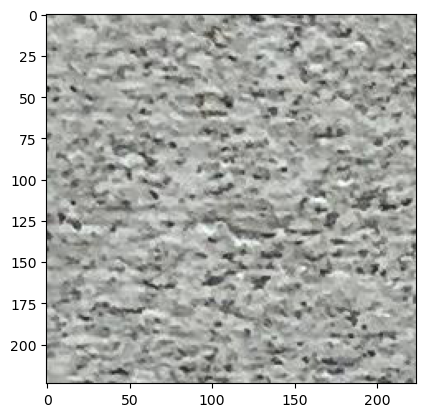

In [22]:
model = torch.load(PATH)
model.eval()

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor=tensor.to(device)
    output = model.forward(tensor)
    
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), crack[classes.item()]

image_path="/Volumes/Project/Competition/IIT Madras/dataset/valid/Negative/IMG_3077_5_5.jpg"
image = plt.imread(image_path)
plt.imshow(image)

with open(image_path, 'rb') as f:
    image_bytes = f.read()

    conf,y_pre=get_prediction(image_bytes=image_bytes)
    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))